/Users/jaekunpark/Dataset
Predicted: [('n02504458', 'African_elephant', 0.909421), ('n01871265', 'tusker', 0.086182885), ('n02504013', 'Indian_elephant', 0.0043545826)]
CPU times: user 4.61 s, sys: 510 ms, total: 5.12 s
Wall time: 2.18 s


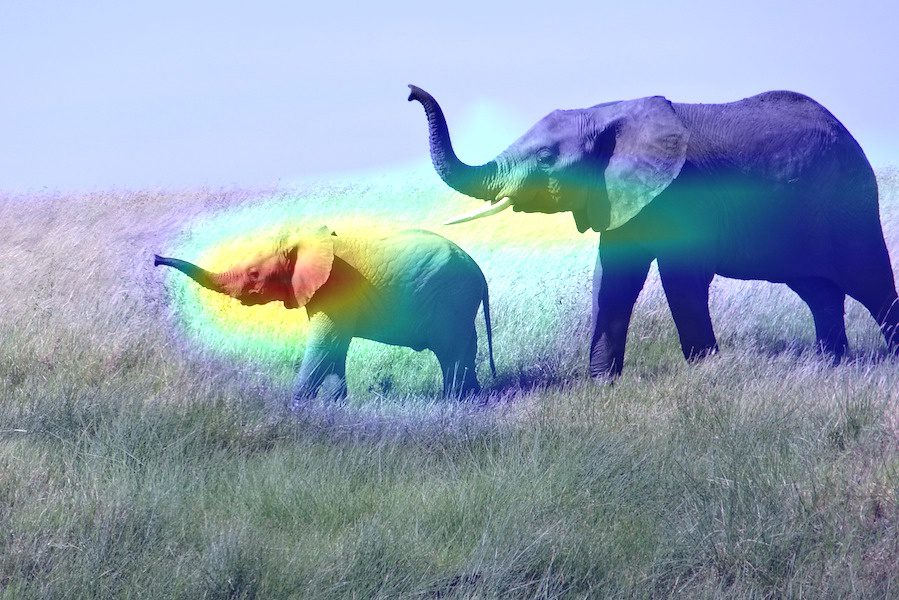

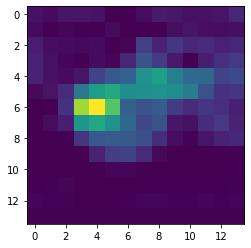

In [7]:
%%time

# 클래스 활성화의 히트맵 시각화
# 이미지의 어느 부분이 컨브넷의 최종 분류 결정에 기여하는지, 분류에 실수가 있는 경우 컨브넷의 결정 과정을 디버깅 하는데, 이미지에 특정 물체가 있는
# 위치를 파악하는데 사용 할 수 있다.

# cf) Grad-CAM : Visual Explanatioins from Deep Networks via Gradient-based Localization
# 입력 이미지가 주어지면 합성곱 층에 있는 특성 맵의 출력을 추출, 특성 맵의 모든 채널 출력에 대한 클래스의 그래디언트 평균을 곱셈

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import cv2


from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

import PIL.Image as pilimg
tf.compat.v1.disable_eager_execution()

model = VGG16(weights = 'imagenet')

currentPath = os.getcwd()
print(currentPath)
os.chdir('/Users/jaekunpark/Dataset')

img_path = '/Users/jaekunpark/Dataset/elephant.jpeg'

img = image.load_img(img_path, target_size = (224, 224))
    # 224*224 크기의 파이썬 이미징 라이브러리 (PIL) 객체로 변환된다. (이 모델이 224*224에서 훈련)
x = image.img_to_array(img)
    # (224, 224, 3)크기의 넘파이 float32 배열
x = np.expand_dims(x, axis = 0)
    # 차원을 추가하여 (1, 224, 224, 3)크기의 배치로 배열을 반환
x = preprocess_input(x)
    # 데이터 전처리(채널별 컬러 정규화) 
    #(VGG모델은 Caffe라이브러리에서 훈련되어 입력데이터의 이미지 채널을 RGB에서 BGR로 바꾸고
    #ImageNet 데이터셋에서 구한 채널별 평균값 [103.939, 116.779, 123.68]을 뺀다.)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

np.argmax(preds[0]) # 386

# Grad-CAM 알고리즘 설정
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3') # 마지막 합성곱 층인 block5_conv3
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] 
    # block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
pooled_grads = K.mean(grads, axis = (0, 1, 2))
    # 특성 맵 채널별 그래디언트 평균값이 담긴 (512,)크기의 벡터
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    # 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력 구하기
pooled_grads_value, conv_layer_output_value = iterate([x])
    # 두 마리 코끼리가 있는 샘플 이미지를 주입하고 2개의 넘파이 배열을 얻는다.

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # '아프리카 코끼리' 클래스에 대한 '채널의 중요도'를 특성 맵 배열의 채널에 곱한다.
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
    # 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)


# 원본 이미지에 히트맵 덧붙이기
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # heatmap을 원본 이미지 크기에 맞게 변경
heatmap = np.uint8(255 * heatmap)
    # heatmap을 RGB 포맷으로 변환
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # 히트맵으로 변환
superimposed_img = heatmap * 0.4 + img # 0.4는 히트맵의 강도
cv2.imwrite('/Users/jaekunpark/Dataset/elephant2.jpg', superimposed_img) # 디스크에 이미지를 저장

a = pilimg.open('/Users/jaekunpark/Dataset/elephant2.jpg')
a

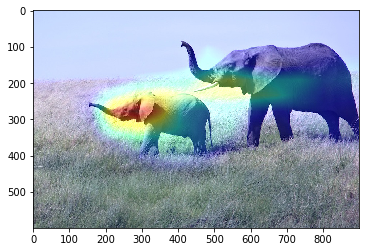

In [3]:
img_path2 = '/Users/jaekunpark/Dataset/elephant2.jpg'
img2 = plt.imread(img_path2)
plt.imshow(img2)